In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

### Load data

In [42]:
path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/clean/merged_dataset_1.csv"
df = pd.read_csv(path)

In [43]:
df = df[df["Year"] == 2018].copy()

In [44]:
df = df.drop(columns=[
    "Well_ID", "BRO-ID", "Filter", "Date", "geometry", "distance_m", "Year", "Unnamed: 0"
])

In [45]:
categorical_cols = ["HGRnaam", "Landuse_Code"]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ["Nitrate"]]

In [46]:
X = df.drop(columns=["Nitrate"])  # drop both targets
y_log = np.log1p(df["Nitrate"].values.reshape(-1, 1)).ravel()  # log(1 + nitrate)

In [34]:
target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_log).ravel()

In [182]:
# X = df.drop(columns="Nitrate")
# y = df["Nitrate"]

In [102]:
# combined = pd.concat([X, pd.DataFrame(y, columns=["avg_depth_m"])], axis=1)
# combined_clean = combined.dropna(subset=["avg_depth_m"])

# # Now separate back
# X = combined_clean.drop(columns=["avg_depth_m"])
# y = combined_clean["avg_depth_m"].values.reshape(-1, 1)

In [47]:
# preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])


In [48]:
# full pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [49]:
# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions back to log scale, then original nitrate units
y_pred_log = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_log = target_scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_original = np.expm1(y_pred_log)  # reverse log1p
y_test_original = np.expm1(y_test_log)

# evaluate
print("MSE:", mean_squared_error(y_test_original, y_pred_original))
print("R2 Score:", r2_score(y_test_original, y_pred_original))

MSE: 82.23808969909368
R2 Score: 0.30460248733660433


In [51]:
param_grid = {
    'regressor__n_estimators': [50, 70, 99, 100, 101, 200],
    'regressor__max_depth': [5, 10, 11, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R² score (CV):", grid_search.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best parameters: {'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 101}
Best R² score (CV): 0.19127501013017192


In [52]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Get the best model
best_model = grid_search.best_estimator_

# Predict on test set (still in scaled log space)
y_pred_scaled = best_model.predict(X_test)

# Inverse the scaling and log1p transform to get original nitrate values
y_pred_log = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_log = target_scaler.inverse_transform(y_test.reshape(-1, 1))

y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test_log)

# Evaluate
print("Test MSE:", mean_squared_error(y_test_original, y_pred_original))
print("Test R²:", r2_score(y_test_original, y_pred_original))


Test MSE: 72.18856864833673
Test R²: 0.38958028737701345


In [39]:
# extract trained Random Forest from pipeline
rf = model.named_steps["regressor"]

numerical_cols = preprocessor.transformers_[0][2]
categorical_cols = preprocessor.transformers_[1][2]

ohe = preprocessor.transformers_[1][1].named_steps["onehot"]
ohe_feature_names = list(ohe.get_feature_names_out(categorical_cols))

all_feature_names = numerical_cols + ohe_feature_names

In [193]:
# importances
importances = rf.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

feat_imp_df = pd.DataFrame({
    "Feature": np.array(all_feature_names)[sorted_idx],
    "Importance": importances[sorted_idx]
})

print(feat_imp_df.head(15))


                                              Feature  Importance
0                                         Elevation_m    0.506746
1                                          Population    0.160869
2                                                 lon    0.094939
3                                                 lat    0.089761
4                                         avg_depth_m    0.050155
5                                       avg_temp_mean    0.020816
6                                      avg_precip_sum    0.014235
7                                        HGRnaam_klei    0.013855
8                                        HGRnaam_zand    0.011276
9                                   Landuse_Code_25.0    0.008921
10                                    Total Livestock    0.004801
11                      Mineral fertiliser N/ha in kg    0.002725
12  Municipal waste (1000 tonnes)/Total municipal ...    0.002674
13                                  Landuse_Code_28.0    0.002495
14        

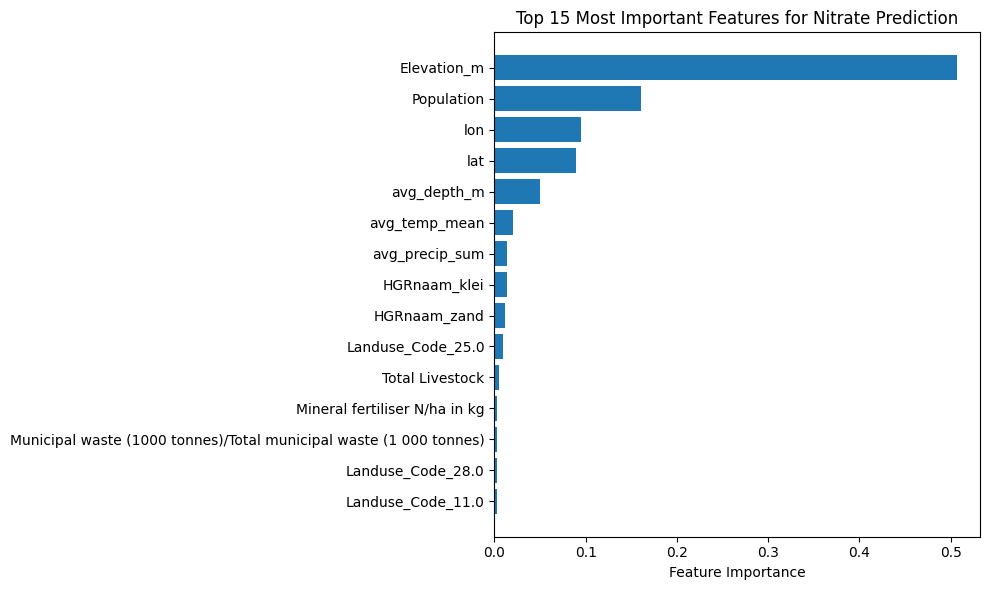

In [194]:
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["Feature"][:15][::-1], feat_imp_df["Importance"][:15][::-1])
plt.title("Top 15 Most Important Features for Nitrate Prediction")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()